In part 3 we'll use the fact that emissions have yearly pattern. 

Let's load the datasets and compare years (straight lines represent the absence of covid data):

In [363]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
train_full_original = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK')
location_group_train = pd.read_csv('new_datasets/train_and_cv_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
train_full_original["Location_group"] = location_group_train
test_original = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK')
location_group_test = pd.read_csv('new_datasets/test_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
test_original["Location_group"] = location_group_test

test_weeks = 49


four_representatives = pd.read_csv('new_datasets/four_representatives.csv', index_col=0)
four_representatives.columns = ["Location"]
four_representatives["Group"] = ['Special 1', 'Special 2', 'High', 'Low']


# Create date feature
train_full_original['date'] = pd.to_datetime(train_full_original.year.astype(str), format='%Y') + \
                     pd.to_timedelta(train_full_original.week_no.mul(7).astype(str) + ' days')
test_original['date'] = pd.to_datetime(test_original.year.astype(str), format='%Y') + \
                     pd.to_timedelta(test_original.week_no.mul(7).astype(str) + ' days')

# Create Location feature
train_full_original["Location"] = train_full_original['latitude'].astype('string') + \
       train_full_original['longitude'].astype('string')
test_original["Location"] = test_original['latitude'].astype('string') + test_original['longitude'].astype('string')

# Pre-covid data
train_precovid_original = train_full_original[train_full_original['date'] < pd.to_datetime('2020-03-18')].copy(deep=True)
precovid_weeks = 53 + len(train_precovid_original[train_precovid_original['year'] == 2020]['week_no'].unique())

# Post-covid data
train_postcovid_original = train_full_original[train_full_original['date'] >  pd.to_datetime('2020-08-26')].copy(deep=True)

# No-covid data
train_nocovid_original = pd.concat([train_precovid_original, train_postcovid_original])

CPU times: total: 1.59 s
Wall time: 1.77 s


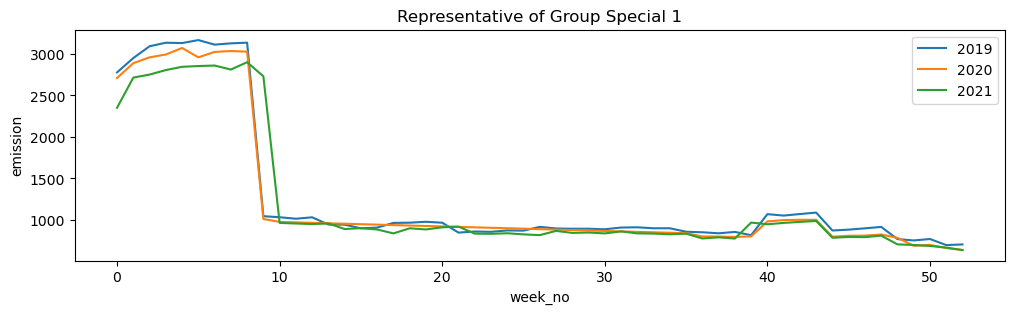

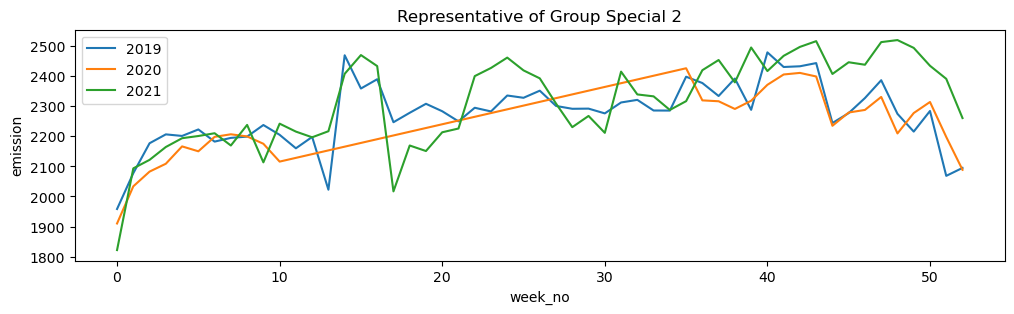

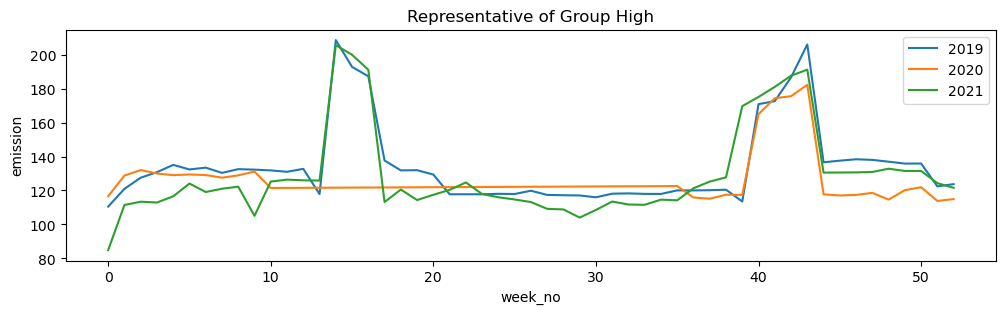

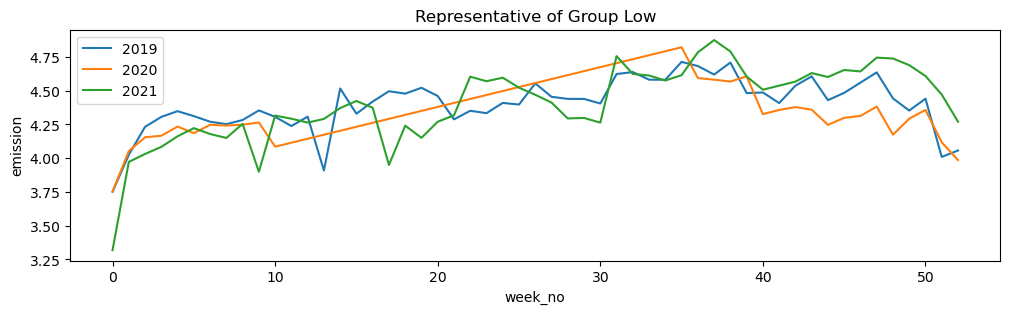

CPU times: total: 1.09 s
Wall time: 2.13 s


In [364]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns


for i, representative in four_representatives.iterrows():
    
    fig, ax = plt.subplots(figsize=(12, 3))
    for year in [2019, 2020, 2021]:
        sns.lineplot(data = train_nocovid_original[(train_nocovid_original["Location"] == representative['Location']) &
                                 (train_nocovid_original['year'] == year)], x='week_no', y='emission', label=year).\
                set(title='Representative of Group {}'.format(representative["Group"]))
    plt.show()

## 00. One year ago

Our first tactic will be forecasting that emissions will be equal to emissions one year ago at the same location (if one year ago was 'the covid period', then we'll take emissions 2 years ago). We won't use 'the covid period' rows.

In [365]:
%%time

study_number = '00'

## Create a pivot table with emissions by year, week_no and location
emissions_by_week = pd.pivot_table(train_nocovid_original, index=['year', 'week_no'], columns='Location', values='emission')


# For the COVID period -- shift one year back.
for w in range(11, 35):
    emissions_by_week.loc[(2020, w), :] = emissions_by_week.loc[(2019, w), :]



## Create the new feature
for i in train_nocovid_original[train_nocovid_original['year'] > 2019].index:
    train_nocovid_original.loc[i, 'OneYearAgo'] = emissions_by_week.loc[(train_nocovid_original.loc[i, 'year'] - 1,
                                                                        train_nocovid_original.loc[i, 'week_no']),
                                                                        train_nocovid_original.loc[i, 'Location']]
for i in test_original.index:
    test_original.loc[i, 'OneYearAgo'] = emissions_by_week.loc[(test_original.loc[i, 'year'] - 1,
                                                                        test_original.loc[i, 'week_no']),
                                                                        test_original.loc[i, 'Location']]
    
test_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Data columns (total 78 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   latitude                                                  24353 non-null  float64       
 1   longitude                                                 24353 non-null  float64       
 2   year                                                      24353 non-null  int64         
 3   week_no                                                   24353 non-null  int64         
 4   SulphurDioxide_SO2_column_number_density                  18211 non-null  float64       
 5   SulphurDioxide_SO2_column_number_density_amf              18211 non-null  float64       
 6   SulphurDioxide_SO2_slant_column_number_density            18211 non-null  float64       
 7   Sul

Let's look at a scatterplot of 'emission' vs. 'OneYearAgo':

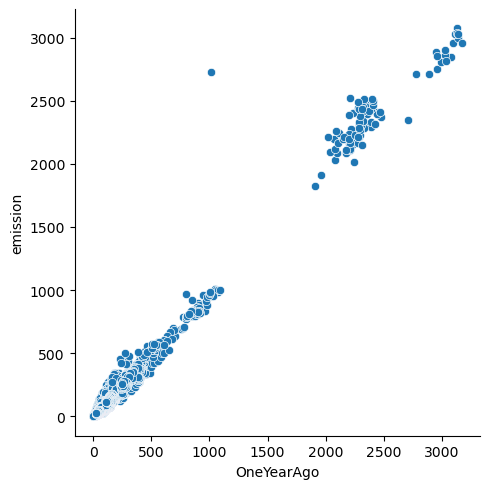

CPU times: total: 281 ms
Wall time: 345 ms


In [366]:
%%time

sns.relplot(data=train_nocovid_original, x='OneYearAgo', y='emission')
plt.show()

Let's test:

In [367]:
%%time

from sklearn.metrics import mean_squared_error

# Create RMSE DataFrame
scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], '2020 RMSE': [], '2021 RMSE': [], 'Test RMSE': []})

prediction_variable = 'OneYearAgo'

scores_df.loc[int(study_number), 'Comment'] = prediction_variable

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable]
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 46.9 ms
Wall time: 55.9 ms


In [368]:
scores_df.loc[int(study_number), 'Test RMSE'] = 31.65412
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412


## 01. Maximum of previous years

We saw before, that for the most of the locations there is a growing trend. What if we predict that emissions will be maximum of previous years?

In [369]:
%%time

study_number = '01'

prediction_variable = 'Max_train'

## FOR TRAIN SCORES

## Create a pivot table with maximal emissions by week_no and location
max_emissions_by_week = pd.pivot_table(train_full_original[train_full_original['year'] < 2021],
                                                              index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.max)

## Create the new feature
for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable] = max_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]
                                                              


CPU times: total: 8.7 s
Wall time: 10.7 s


Let's look at a scatterplot of 'emission' vs. 'Max':

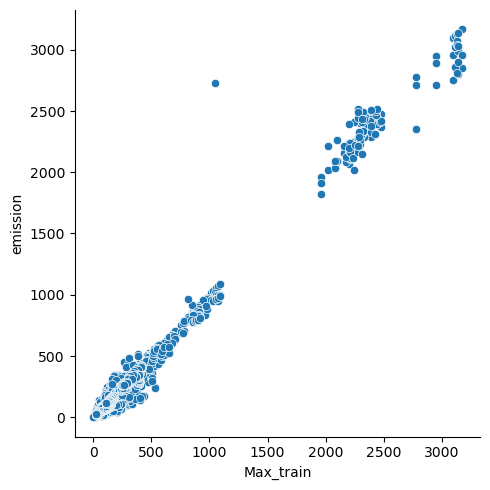

CPU times: total: 328 ms
Wall time: 453 ms


In [370]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable, y='emission')
plt.show()

Let's test:

In [371]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable]
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
    
    
## FOR TEST AND FUTURE PURPOSES 

prediction_variable = 'Max'

scores_df.loc[int(study_number), 'Comment'] = prediction_variable


max_emissions_by_week = pd.pivot_table(train_full_original, index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.max)          

## Create the new feature
for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable] = max_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]                                                                                               
                                                              
for i in test_original.index:
    test_original.loc[i, prediction_variable] = max_emissions_by_week.loc[test_original.loc[i, 'week_no'],
                                                                        test_original.loc[i, 'Location']]

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 11.7 s
Wall time: 13.4 s


In [372]:
scores_df.loc[int(study_number), 'Test RMSE'] = 23.02231
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231


## 02 Max with coeffs for groups

Our next strategy will be multiplication of 'Max' by coeffs, 4 different coeffs for 4 different Location groups (see Part 1).

We'll find these coeffs wit hyperparameter tuning in ['studies/3_02.py']('studies/3_02.py') (optimizing for 2021).

In [373]:
study_number = '02'
prediction_variable = 'Max_x_groups'

train_nocovid_original.to_csv('new_datasets/train_3_{}.csv'.format(study_number))

In [374]:
import pickle

with open('studies/3_' + study_number + '_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
    
# print("Best Cross-val RMSE:", study.best_trial.value)
print("Best hyperparameters:", best_params)

Best hyperparameters: {'Special 1': 0.929, 'Special 2': 1.0170000000000001, 'High': 0.936, 'Low': 0.932}


Now, let's apply these coeffs:

In [375]:
## FOR TRAIN SCORES
train_nocovid_original[prediction_variable + '_train'] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Max_train']                          

Let's look at a scatterplot of 'emission' vs. 'Max_multiplied_train', then test:

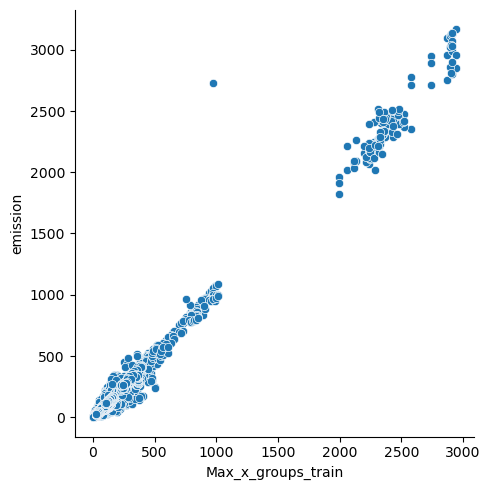

CPU times: total: 297 ms
Wall time: 381 ms


In [376]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable + '_train', y='emission')
plt.show()

In [377]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, 
                                      prediction_variable + '_train']
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
    
    
## FOR TEST AND FUTURE PURPOSES 


scores_df.loc[int(study_number), 'Comment'] = prediction_variable

## Create the new feature
train_nocovid_original[prediction_variable] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Max']  

test_original[prediction_variable] = test_original['Location_group'].map(best_params) * \
        test_original['Max'] 

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 46.9 ms
Wall time: 53.9 ms


In [378]:
scores_df.loc[int(study_number), 'Test RMSE'] = 21.67107
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107


## 03. Median with coeffs for groups

Note, the coefficients we've found in the study 02 were, mostly, < 1. What if we take medians instead of maximums? We won't use 'the covid period' in calculating medians.

In [379]:
%%time

study_number = '03'

## FOR TRAIN SCORES


## First, let's calculate Median
prediction_variable = 'Median'

# Create a pivot table with maximal emissions by week_no and location
median_emissions_by_week = pd.pivot_table(train_nocovid_original[train_nocovid_original['year'] < 2021],
                                                              index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.median)


for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable + '_train'] = \
                                                median_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]

prediction_variable = 'Median_x_groups'

train_nocovid_original.to_csv('new_datasets/train_3_{}.csv'.format(study_number))


CPU times: total: 14.7 s
Wall time: 17.8 s


In [380]:
with open('studies/3_' + study_number + '_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
    
# print("Best Cross-val RMSE:", study.best_trial.value)
print("Best hyperparameters:", best_params)

Best hyperparameters: {'Special 1': 0.9420000000000001, 'Special 2': 1.02, 'High': 0.9670000000000001, 'Low': 0.9530000000000001}


Now, let's apply these coeffs:

In [381]:
train_nocovid_original[prediction_variable + '_train'] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Median_train']   

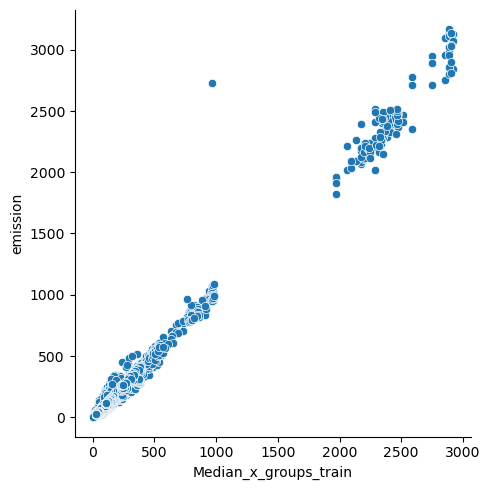

CPU times: total: 297 ms
Wall time: 344 ms


In [382]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable + '_train', y='emission')
plt.show()

In [383]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable + '_train']
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
    
scores_df.loc[int(study_number), 'Comment'] = prediction_variable


## FOR TEST AND FUTURE PURPOSES 

## First, let's calculate Median
prediction_variable = 'Median'

# Create a pivot table with maximal emissions by week_no and location
median_emissions_by_week = pd.pivot_table(train_nocovid_original,
                                                              index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.median)


for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable] = \
                                                median_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]
    
for i in test_original.index:
    test_original.loc[i, prediction_variable] = median_emissions_by_week.loc[test_original.loc[i, 'week_no'],
                                                                        test_original.loc[i, 'Location']]

## Now, create the new feature
prediction_variable = 'Median_x_groups'

train_nocovid_original[prediction_variable] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Median']   
 
test_original[prediction_variable] = test_original['Location_group'].map(best_params) * \
        test_original['Median'] 

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 11.7 s
Wall time: 13.5 s


In [384]:
scores_df.loc[int(study_number), 'Test RMSE'] = 35.27105
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105


Strangely, test results for Median_x_groups are much worse, than for Max_x_groups.

## 04. Max with coeffs based on features

Next strategy we'll try will be to calculate a separate 'Max' scaling coefficient for each Location-week_no combination. This coefficient will be a median of growth factors of all features for that combination:

In [385]:
%%time

study_number = '04'

prediction_variable = 'Max_x_features'

scores_df.loc[int(study_number), 'Comment'] = prediction_variable

## For technical purposes, create a new feature: Location_week_no
train_nocovid_original['Location_week_no'] = train_nocovid_original['Location'] + '_' + \
                                                train_nocovid_original['week_no'].astype('str')
test_original['Location_week_no'] = test_original['Location'] + '_' \
                                        + test_original['week_no'].astype('str')

## FOR TRAIN SCORES

# Past years' maximums of features for each week and location
max_by_week = pd.pivot_table(train_nocovid_original[train_nocovid_original['year'] < 2021],
                                                              index=['Location_week_no'],
           values=train_nocovid_original.columns.difference(['latitude', 'longitude', 'year', 'week_no', 'emission',
                    'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
                                                            'Max_x_groups', 'Location_week_no',
                                                            'Median_train', 'Median', 'Median_x_groups_train',
                                                            'Median_x_groups']),
                                  aggfunc=np.max)



# Values of features for each week and location
last_by_week = pd.pivot_table(train_nocovid_original[train_nocovid_original['year'] == 2021],
                                                              index=['Location_week_no'],
           values=train_nocovid_original.columns.difference(['latitude', 'longitude', 'year', 'week_no', 'emission',
                    'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
                                                            'Max_x_groups', 'Location_week_no',
                                                            'Median_train', 'Median', 'Median_x_groups_train',
                                                            'Median_x_groups']))


# Growth factors of features for each week and location
feature_growth = last_by_week.sort_index() / max_by_week.sort_index()

# Median growth factor of features for each week and location
median_growth = feature_growth.median(axis=1)

## Create the new feature
train_nocovid_original[prediction_variable + '_train'] = train_nocovid_original['Max_train'] * \
                train_nocovid_original['Location_week_no'].map(median_growth)
                                
## Fill the rows without observations with original values
train_nocovid_original.loc[train_nocovid_original[prediction_variable + '_train'].isna(), prediction_variable + '_train'] = \
        train_nocovid_original.loc[train_nocovid_original[prediction_variable + '_train'].isna(), 'Max_train']



CPU times: total: 266 ms
Wall time: 342 ms


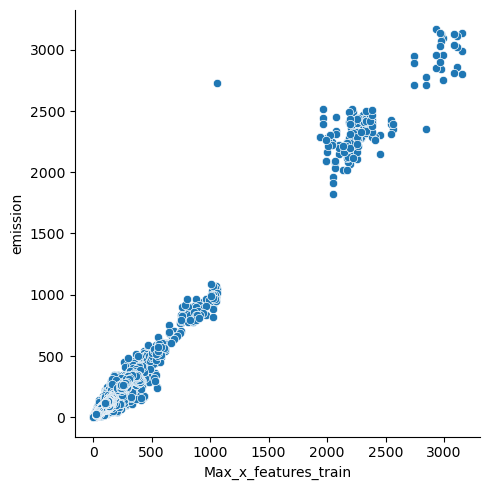

CPU times: total: 266 ms
Wall time: 347 ms


In [386]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable + '_train', y='emission')
plt.show()

In [387]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable + '_train']
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
## FOR TEST AND FUTURE PURPOSES (TODO)


# # Past years' maximums of features for each week and location
# max_by_week = pd.pivot_table(train_nocovid_original, index=['Location_week_no'],
#            values=train_nocovid_original.columns.difference(['latitude', 'longitude', 'year', 'week_no', 'emission',
#                     'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
#                                                             'Max_x_groups', 'Location_week_no', 'Max_x_features_train']),
#                                   aggfunc=np.max)

# # Values of features for each week and location
# last_by_week = pd.pivot_table(test_original, index=['Location_week_no'],
#            values=test_original.columns.difference(['latitude', 'longitude', 'year', 'week_no',
#                     'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
#                                                             'Max_x_groups', 'Location_week_no']))

# # Growth factors of features for each week and location
# feature_growth = last_by_week / max_by_week

# # Median growth factor of features for each week and location
# median_growth = feature_growth.median(axis=1)

# ## Create the new feature
# train_nocovid_original[prediction_variable] = train_nocovid_original['Max'] * \
#                 train_nocovid_original['Location_week_no'].map(median_growth)
# test_original[prediction_variable] = test_original['Max']  * \
#                  test_original['Location_week_no'].map(median_growth)


# ## Fill the rows without observations with original values
# train_nocovid_original.loc[train_nocovid_original[prediction_variable].isna(), prediction_variable] = \
#         train_nocovid_original.loc[train_nocovid_original[prediction_variable].isna(), 'Max']
# test_original.loc[test_original[prediction_variable].isna(), prediction_variable] = \
#         test_original.loc[test_original[prediction_variable].isna(), 'Max']
                            

# # Prepare submission file
# submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
#                            'emission': test_original[prediction_variable]})

# submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 0 ns
Wall time: 7.13 ms


In [388]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105
4,Max_x_features,NaN,13.270579,22.794264,NaN


## 05. Max with coeffs for locations

In [389]:
study_number = '05'

prediction_variable = 'Max_x_locations'

scores_df.loc[int(study_number), 'Comment'] = prediction_variable

with open('studies/3_' + study_number + '_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

In [390]:
## FOR TRAIN and CV SCORES
train_nocovid_original[prediction_variable + '_train'] = \
        train_nocovid_original['Location'].map(best_params) * \
        train_nocovid_original['Max_train']    


# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, 
                                      prediction_variable + '_train']
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
## FOR TEST 

train_nocovid_original[prediction_variable] = \
        train_nocovid_original['Location'].map(best_params) * \
        train_nocovid_original['Max']  

test_original[prediction_variable] = test_original['Location'].map(best_params) * \
        test_original['Max'] 

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

In [391]:
scores_df.loc[int(study_number), 'Test RMSE'] = 20.71237
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105
4,Max_x_features,NaN,13.270579,22.794264,NaN
5,Max_x_locations,NaN,13.416531,20.034434,20.71237


## 06. Mean Target Encoding of week_no

C:\Users\mikej\AppData\Local\Temp\ipykernel_34244\3026479603.py:10: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  train_nocovid_original_grouped = train_nocovid_original.groupby(['year', 'date']).agg(np.mean)


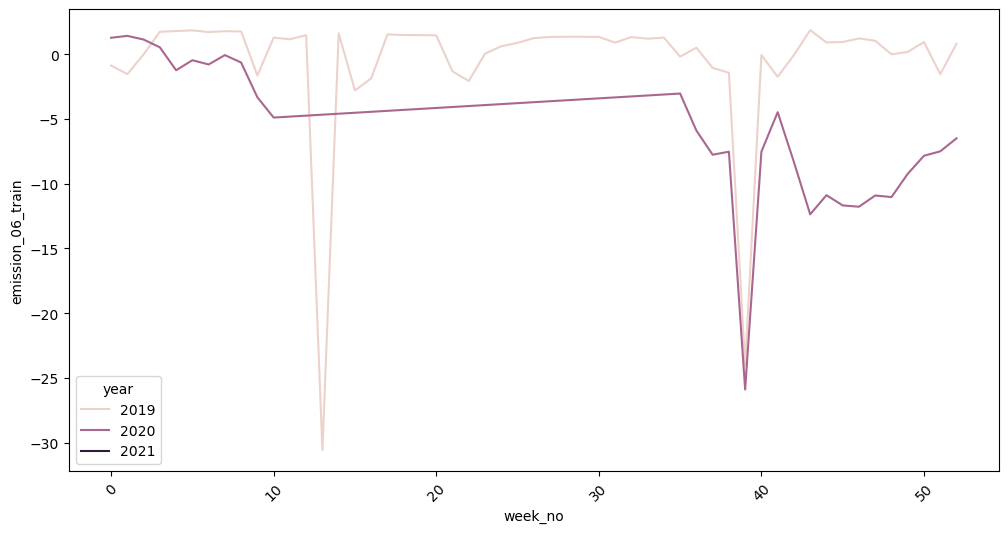

C:\Users\mikej\AppData\Local\Temp\ipykernel_34244\3026479603.py:22: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  train_nocovid_original_grouped = train_nocovid_original.groupby(['year', 'date']).agg(np.mean)


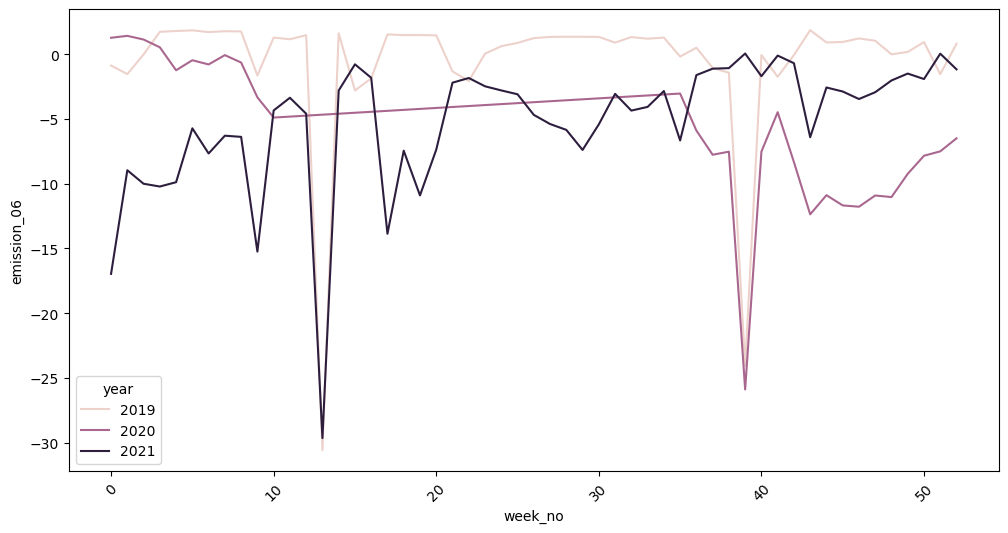

In [392]:
study_number = '06'

scores_df.loc[int(study_number), 'Comment'] = '+ week_no_enc'

train_nocovid_original.loc[train_nocovid_original['year'] < 2021,
                           'emission_{}_train'.format(study_number)] = \
            train_nocovid_original.loc[train_nocovid_original['year'] < 2021, 'emission'] - \
            train_nocovid_original.loc[train_nocovid_original['year'] < 2021, 'Max_x_locations']

train_nocovid_original_grouped = train_nocovid_original.groupby(['year', 'date']).agg(np.mean)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=train_nocovid_original_grouped, x='week_no',
             y='emission_{}_train'.format(study_number), hue='year')
plt.xticks(rotation=45)
plt.show()

train_nocovid_original['emission_{}'.format(study_number)] = \
            train_nocovid_original['emission'] - \
            train_nocovid_original['Max_x_locations']

train_nocovid_original_grouped = train_nocovid_original.groupby(['year', 'date']).agg(np.mean)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=train_nocovid_original_grouped, x='week_no', 
             y='emission_{}'.format(study_number), hue='year')
plt.xticks(rotation=45)
plt.show()

In [393]:
from feature_engine.encoding import MeanEncoder

encoder = MeanEncoder()

train_nocovid_original['week_no_category'] = train_nocovid_original['week_no'].astype('category')
test_original['week_no_category'] = test_original['week_no'].astype('category')

all_features_train = train_nocovid_original[train_nocovid_original['year'] < 2021].copy(deep=True)
all_features_cv = train_nocovid_original[train_nocovid_original['year'] == 2021].copy(deep=True)
all_features_train_and_cv = train_nocovid_original.copy(deep=True)
all_features_test = test_original.copy(deep=True)

## FOR CROSS-VALIDATION

all_features_train['week_no_enc_train'] = encoder.fit_transform( \
                all_features_train[['week_no_category']],
                all_features_train['emission_{}'.format(study_number)])
all_features_cv['week_no_enc_train'] = encoder.transform(all_features_cv[['week_no_category']])

feature_name = 'week_no_enc_train'
for data in [all_features_train, all_features_cv]:
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())

<class 'pandas.core.series.Series'>
Index: 40754 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2020_52
Series name: week_no_enc_train
Non-Null Count  Dtype  
--------------  -----  
40754 non-null  float64
dtypes: float64(1)
memory usage: 1.6+ MB
None
count    40754.000000
mean        -2.507701
std          5.377268
min        -30.584286
25%         -4.467214
50%         -1.788436
75%          0.870623
max          1.631511
Name: week_no_enc_train, dtype: float64
Unique Values and their count:
 0.214260     994
-5.240833     994
-2.683081     994
-4.396620     994
-4.467214     994
-24.985484    994
-3.781094     994
-3.097987     994
-4.184556     994
-4.977265     994
-0.043375     994
-5.354463     994
-5.268021     994
-4.923184     994
-5.508549     994
-4.516676     994
-3.438390     994
-4.509492     994
-1.593523     994
-2.830336     994
 0.575253     994
 1.150398     994
 0.293012     994
 0.705720     994
 0.476082     994
 0.870623     994
 0.573698     994
-2.4728

In [394]:
%%time

selected_columns = [feature_name]

train = all_features_train[selected_columns]
target_train = all_features_train['emission_{}'.format(study_number)]
cv = all_features_cv[selected_columns]
target_cv = all_features_cv['emission_{}'.format(study_number)]


import xgboost as xgb

model = xgb.XGBRegressor(random_state=SEED, n_jobs=-1)

# Calculate train and cross-val RMSEs
model.fit(train, target_train)
pred_1 = model.predict(train)
pred_final = pred_1 + all_features_train['Max_x_locations_train']
score = mean_squared_error(all_features_train['emission'], pred_final, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score

pred_1 = model.predict(cv)
pred_final = pred_1 + all_features_cv['Max_x_locations_train']
score = mean_squared_error(all_features_cv['emission'], pred_final, squared=False)
scores_df.loc[int(study_number), '2021 RMSE'] = score

scores_df

CPU times: total: 1.88 s
Wall time: 205 ms


,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105
4,Max_x_features,NaN,13.270579,22.794264,NaN
5,Max_x_locations,NaN,13.416531,20.034434,20.71237
6,+ week_no_enc,12.76726,NaN,20.766828,NaN


In [395]:
## FOR TEST AND FUTURE PURPOSES

all_features_train_and_cv['week_no_enc'] = encoder.fit_transform( \
                all_features_train_and_cv[['week_no_category']],
                                all_features_train_and_cv['emission_{}'.format(study_number)])
all_features_test['week_no_enc'] = encoder.transform(all_features_test[['week_no_category']])

feature_name = 'week_no_enc'
for data in [all_features_train_and_cv, all_features_test]:
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())

<class 'pandas.core.series.Series'>
Index: 67095 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: week_no_enc
Non-Null Count  Dtype  
--------------  -----  
67095 non-null  float64
dtypes: float64(1)
memory usage: 3.0+ MB
None
count    67095.000000
mean        -3.573695
std          4.073166
min        -30.117171
25%         -3.504184
50%         -2.943222
75%         -1.773581
max         -0.579191
Name: week_no_enc, dtype: float64
Unique Values and their count:
-5.510594     1491
-5.626788     1491
-2.321694     1491
-3.298622     1491
-3.331081     1491
-16.633693    1491
-3.082234     1491
-2.095133     1491
-3.015838     1491
-4.169809     1491
-3.012960     1491
-4.524793     1491
-4.660950     1491
-4.255549     1491
-4.343148     1491
-3.504184     1491
-2.926393     1491
-2.986856     1491
-3.278571     1491
-2.271025     1491
-2.948450     1491
-2.636359     1491
-3.096660     1491
-1.433533     1491
-2.234181     1491
-1.513330     1491
-1.741576  

In [396]:
%%time

selected_columns = [feature_name]

train_and_cv = all_features_train_and_cv[selected_columns]
target_train_and_cv = all_features_train_and_cv['emission_{}'.format(study_number)]
test = all_features_test[selected_columns]

# Prepare submission
model.fit(train_and_cv, target_train_and_cv)
pred_1 = model.predict(train_and_cv)
pred_final_train_and_cv = pred_1 + all_features_train_and_cv['Max_x_locations']

pred_1 = model.predict(test)
pred_final_test = pred_1 + all_features_test['Max_x_locations']
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': pred_final_test})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 3.97 s
Wall time: 375 ms


In [397]:
scores_df.loc[int(study_number), 'Test RMSE'] = 24.37542
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105
4,Max_x_features,NaN,13.270579,22.794264,NaN
5,Max_x_locations,NaN,13.416531,20.034434,20.71237
6,+ week_no_enc,12.76726,NaN,20.766828,24.37542


## 07. Removing the special week effect (naive approach)

<timed exec>:5: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:21: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.


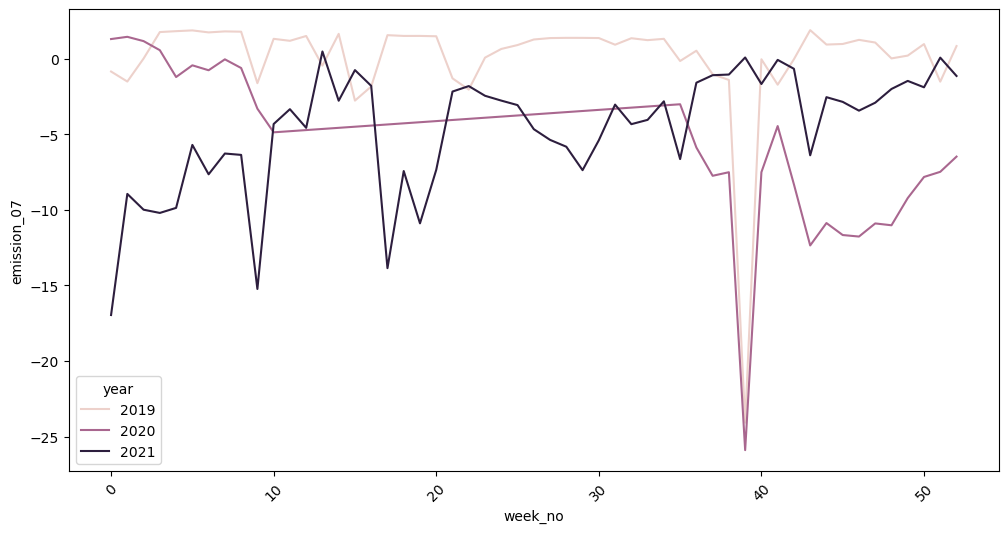

CPU times: total: 203 ms
Wall time: 232 ms


In [398]:
%%time

study_number = '07'

scores_df.loc[int(study_number), 'Comment'] = '5 - Special week'

all_features_train_and_cv_grouped = all_features_train_and_cv.groupby(['week_no']).agg(np.mean)

special_week = all_features_train_and_cv_grouped['emission_06'].sort_values().head(1).index.values[0]
special_difference = all_features_train_and_cv_grouped['emission_06'].sort_values().head(1).values[0]


for data in [all_features_train, all_features_cv, all_features_train_and_cv]:
    data['Max_x_locations_corrected'] = data['Max_x_locations']
    data.loc[data['week_no'] == special_week, 'Max_x_locations_corrected'] = \
                data.loc[data['week_no'] == special_week, 'Max_x_locations_corrected'] + special_difference
    
    data['emission_07'] = data['emission'] - data['Max_x_locations_corrected']
    #print(data.loc[data['week_no'] == special_week, ['Max_x_locations', 'Max_x_locations_corrected']].mean().head(5))

    

all_features_train_and_cv_grouped = all_features_train_and_cv.groupby(['year', 'week_no']).agg(np.mean)
        
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=all_features_train_and_cv_grouped, x='week_no', 
             y='emission_07', hue = 'year')
plt.xticks(rotation=45)
plt.show()

In [399]:

# Calculate train and cross-val RMSEs

pred_final = all_features_train['Max_x_locations_corrected']
score = mean_squared_error(all_features_train['emission'], pred_final, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score

pred_final = all_features_cv['Max_x_locations_corrected']
score = mean_squared_error(all_features_cv['emission'], pred_final, squared=False)
scores_df.loc[int(study_number), '2021 RMSE'] = score

scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105
4,Max_x_features,NaN,13.270579,22.794264,NaN
5,Max_x_locations,NaN,13.416531,20.034434,20.71237
6,+ week_no_enc,12.767260,NaN,20.766828,24.37542
7,5 - Special week,18.735625,NaN,14.507754,NaN


In [400]:
## FOR TESTING

all_features_test['Max_x_locations_corrected'] = all_features_test['Max_x_locations']
all_features_test.loc[all_features_test['week_no'] == special_week, 'Max_x_locations_corrected'] = \
                all_features_test.loc[all_features_test['week_no'] == \
                                      special_week, 'Max_x_locations_corrected'] + special_difference

pred_final_test = all_features_test['Max_x_locations_corrected']

submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': pred_final_test})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

In [401]:
all_features_test['Max_x_locations_corrected']

ID_LAT_LON_YEAR_WEEK
ID_-0.510_29.290_2022_00     3.404516
ID_-0.510_29.290_2022_01     3.675133
ID_-0.510_29.290_2022_02     3.837863
ID_-0.510_29.290_2022_03     3.904894
ID_-0.510_29.290_2022_04     3.943017
                              ...    
ID_-3.299_30.301_2022_44    32.905251
ID_-3.299_30.301_2022_45    33.430116
ID_-3.299_30.301_2022_46    33.811731
ID_-3.299_30.301_2022_47    34.111973
ID_-3.299_30.301_2022_48    32.489637
Name: Max_x_locations_corrected, Length: 24353, dtype: float64

In [402]:
scores_df.loc[int(study_number), 'Test RMSE'] = 23.84005
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105
4,Max_x_features,NaN,13.270579,22.794264,NaN
5,Max_x_locations,NaN,13.416531,20.034434,20.71237
6,+ week_no_enc,12.767260,NaN,20.766828,24.37542
7,5 - Special week,18.735625,NaN,14.507754,23.84005


## 08. Removing the special week effect (per location)

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:9: FutureWarning: The operation <function mean at 0x00000201B3282320> f

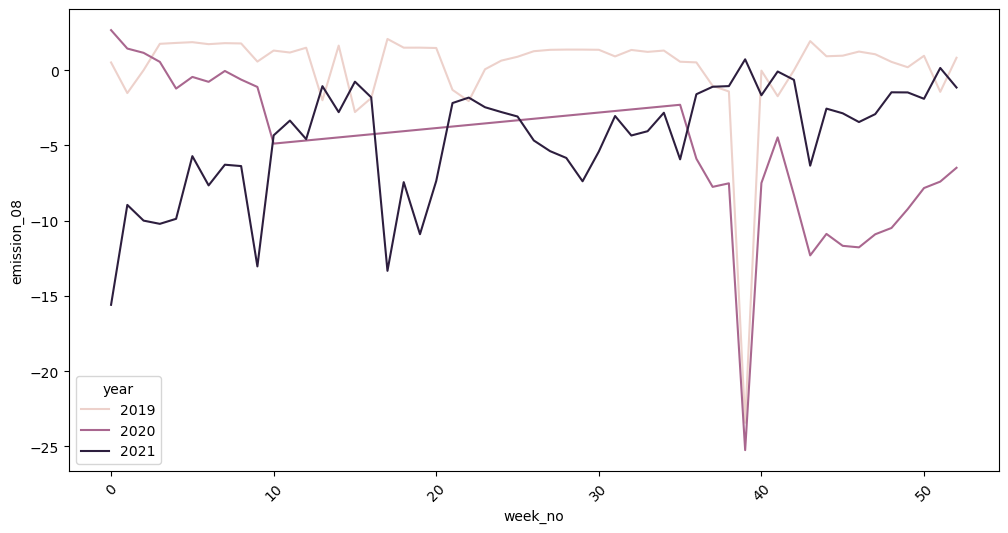

CPU times: total: 10 s
Wall time: 12 s


In [403]:
%%time

study_number = '08'

scores_df.loc[int(study_number), 'Comment'] = '5 - SW per location'



for location in all_features_train['Location'].unique():
    all_features_train_and_cv_grouped = all_features_train_and_cv[all_features_train_and_cv['Location'] == \
                                        location].groupby(['week_no']).agg(np.mean)
    special_week = all_features_train_and_cv_grouped['emission_06'].sort_values().head(1).index.values[0]
    special_difference = all_features_train_and_cv_grouped['emission_06'].sort_values().head(1).values[0]
    
    for dataset in [all_features_train, all_features_cv, all_features_train_and_cv]:
        
        data = dataset[dataset["Location"] == location].copy(deep=True)
        
        data['Max_x_locations_corrected'] = data['Max_x_locations']
        data.loc[data['week_no'] == special_week, 'Max_x_locations_corrected'] = \
                    data.loc[data['week_no'] == special_week, 'Max_x_locations_corrected'] + special_difference

        data['emission_08'] = data['emission'] - data['Max_x_locations_corrected']
        
        dataset.loc[data.index, 'Max_x_locations_corrected'] = data['Max_x_locations_corrected']
        dataset.loc[data.index, 'emission_08'] = data['emission_08']
        
    data = all_features_test[all_features_test["Location"] == location].copy(deep=True)
        
    data['Max_x_locations_corrected'] = data['Max_x_locations']
    data.loc[data['week_no'] == special_week, 'Max_x_locations_corrected'] = \
                data.loc[data['week_no'] == special_week, 'Max_x_locations_corrected'] + special_difference

    all_features_test.loc[data.index, 'Max_x_locations_corrected'] = data['Max_x_locations_corrected']


all_features_train_and_cv_grouped = all_features_train_and_cv.groupby(['year', 'week_no']).agg(np.mean)
        
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=all_features_train_and_cv_grouped, x='week_no', 
             y='emission_08', hue = 'year')
plt.xticks(rotation=45)
plt.show()

In [404]:
# Calculate train and cross-val RMSEs

pred_final = all_features_train['Max_x_locations_corrected']
score = mean_squared_error(all_features_train['emission'], pred_final, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score

pred_final = all_features_cv['Max_x_locations_corrected']
score = mean_squared_error(all_features_cv['emission'], pred_final, squared=False)
scores_df.loc[int(study_number), '2021 RMSE'] = score

pred_final_test = all_features_test['Max_x_locations_corrected']

submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': pred_final_test})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

In [405]:
scores_df.loc[int(study_number), 'Test RMSE'] = 31.33883
scores_df

,Comment,Train RMSE,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,NaN,14.299684,19.656364,31.65412
1,Max,NaN,14.089696,21.459546,23.02231
2,Max_x_groups,NaN,11.103670,19.188561,21.67107
3,Median_x_groups,NaN,7.043665,17.888637,35.27105
4,Max_x_features,NaN,13.270579,22.794264,NaN
5,Max_x_locations,NaN,13.416531,20.034434,20.71237
6,+ week_no_enc,12.767260,NaN,20.766828,24.37542
7,5 - Special week,18.735625,NaN,14.507754,23.84005
8,5 - SW per location,14.904315,NaN,14.285672,31.33883


In [406]:
train_nocovid_original.to_csv('new_datasets/train_3_final.csv')
test_original.to_csv('new_datasets/test_3_final.csv')